In [1]:
import dataLoader as loader
import HDDMmodelMaker as ddm
import pandas as pd
import time
import matplotlib.pyplot as plt
import hddm
import random
import scipy.stats as st
import numpy as np
import seaborn as sns
import pymc as mc
import random 
import kabuki
from mpl_toolkits.mplot3d import Axes3D
import statsmodels
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial import distance

/Users/eladiomontero/opt/anaconda3/envs/decTimesEnv/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [2]:
data = hddm.load_csv("data_actions.csv")

In [3]:
def actionChange(actions1, actions2, user1, user2, rt):
    if len(actions1) != len(actions2): return "Lenghts mismatch" #Raise exception
    rounds = len(actions1)
    prev1 = ""
    prev2 = ""
    switch_events = pd.DataFrame(columns=["type", "lag", "subject", "round", "rt"])
    lag = 0
    for r in range(0, rounds):
        if r ==0:
            prev1 = actions1[r]
            prev2 = actions2[r]
            lag += 1
            continue
        elif actions1[r] != prev1:
            switch_events = switch_events.append(
                {"context": prev2, "type": "%s%s" % (prev1, actions1[r]),
                 "lag": lag, "subject": user1, "round": r + 1, "rt": rt[r]}, ignore_index=True)
            lag = 0
        if actions2[r] == prev2:
            lag += 1
        else: lag = 1
        prev1 = actions1[r]
        prev2 = actions2[r]
    return switch_events

In [4]:
def actionCounts(actions, user):
    prosocial = ['CCC', 'CDC', '00C', 'DDC', 'DCC']
    proself = ['DDD', 'DCD', '00D', 'CCD', 'CDD']
    rating = 0
    act_df = {'user':user,'00D':0,'00C':0,'DCD':0,'CDC':0,'CCC':0,'CDD':0,'CCD':0,'DDC':0,'DCC':0,'DDD':0, 'type':""}
    for a in actions:
        act_df[a] = act_df[a] + 1
        if a in prosocial:
            rating = rating + 1
        else: rating = rating - 1
    if rating >= 0: act_df["type"] = "Pro-social"
    else: act_df["type"] = "Pro-self"
    return act_df

In [5]:
switches = pd.DataFrame()
actions = pd.DataFrame()
for t in data.treatment.unique():
    t_df = data.loc[(data.treatment == t)]
    users = t_df.player.unique()
    switchesT = pd.DataFrame()
    actionsT = pd.DataFrame()
    for u in users:
        df = t_df.loc[t_df.player == u]
        df = df.sort_values(by = "round", ascending = True)
        opp = str(df.opponent.unique())
        acc1 = df.action_player.values
        acc2 = df.action_opponent.values
        rt = df["rt"].values
        switchesT = switchesT.append(actionChange(acc1, acc2, u, opp, rt))
        actionsT = actionsT.append(actionCounts(df.actions, u), ignore_index=True)
    switchesT["treatment"] = t
    actionsT["treatment"] = t
    switches = switches.append(switchesT, ignore_index = True)
    actions = actions.append(actionsT, ignore_index = True)

/Users/eladiomontero/opt/anaconda3/envs/decTimesEnv/lib/python2.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [6]:
## Adjusting weights for actions
actions["type_adj"] = ""
actions["score_adj"] = 0

for index, row in actions.iterrows():
    score = sum(row[0:10] * [4,-4,0,-4,4,0,0,-4,4,0])
    actions.iloc[index, 14] = score
    actions.iloc[index, 13] = "Pro-social" if score>=0 else "Pro-self"
actions

,00C,00D,CCC,CCD,CDC,CDD,DCC,DCD,DDC,DDD,type,user,treatment,type_adj,score_adj
0,0.0,1.0,69.0,9.0,1.0,2.0,9.0,1.0,3.0,5.0,Pro-social,s3m7_usuario9,weak,Pro-self,-28.0
1,1.0,0.0,74.0,4.0,9.0,1.0,2.0,1.0,3.0,5.0,Pro-social,s3m7_usuario18,weak,Pro-social,32.0
2,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario7,weak,Pro-social,4.0
3,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario10,weak,Pro-social,4.0
4,1.0,0.0,97.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,Pro-social,s3m7_usuario13,weak,Pro-social,0.0
5,1.0,0.0,98.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario5,weak,Pro-social,8.0
6,0.0,1.0,93.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,Pro-social,s3m7_usuario15,weak,Pro-social,0.0
7,1.0,0.0,93.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,Pro-social,s3m7_usuario16,weak,Pro-social,4.0
8,0.0,1.0,86.0,2.0,1.0,1.0,3.0,3.0,1.0,2.0,Pro-social,s3m7_usuario12,weak,Pro-self,-16.0
9,1.0,0.0,88.0,0.0,3.0,3.0,1.0,1.0,2.0,1.0,Pro-social,s3m7_usuario6,weak,Pro-social,20.0


In [7]:
data_svo = pd.merge(data, actions[["type_adj", "user"]], left_on = "player", right_on = "user")
data_svo.opponent = data_svo['opponent'].str.strip("['']")

In [8]:
fix = data_svo[data_svo.treatment == "fix"]
fix.head()

,Unnamed: 0,round,player,action_player,opponent,action_opponent,payoff,rt,session,treatment,actions,response,abs_time,type_adj,user
1800,1800,1,s4m8_usuario2,D,s4m8_usuario7,C,4,-4.600,s4m8,fix,00D,0,4.600,Pro-self,s4m8_usuario2
1801,1814,2,s4m8_usuario2,D,s4m8_usuario7,C,4,-6.756,s4m8,fix,DCD,0,6.756,Pro-self,s4m8_usuario2
1802,1828,3,s4m8_usuario2,C,s4m8_usuario7,D,0,8.987,s4m8,fix,DCC,1,8.987,Pro-self,s4m8_usuario2
1803,1842,4,s4m8_usuario2,D,s4m8_usuario7,D,1,-5.750,s4m8,fix,CDD,0,5.750,Pro-self,s4m8_usuario2
1804,1856,5,s4m8_usuario2,C,s4m8_usuario7,C,3,10.820,s4m8,fix,DDC,1,10.820,Pro-self,s4m8_usuario2


In [9]:
# Split fix experiment players, 58 total, 40 training, 18 testing
random.seed(1234)
subjects_fix = list(fix.player.unique())
sample_subj = set()
for s in subjects_fix:
    s = random.choice(subjects_fix)
    sample_subj.add(s)
    opponent = fix.loc[fix.player == s].opponent.values[0]
    sample_subj.add(opponent)
    if len(sample_subj) == 40:
        break
train_fix = fix.loc[fix.player.isin(sample_subj)]
test_fix = fix.loc[~fix.player.isin(sample_subj)]

In [11]:
actions

,00C,00D,CCC,CCD,CDC,CDD,DCC,DCD,DDC,DDD,type,user,treatment,type_adj,score_adj
0,0.0,1.0,69.0,9.0,1.0,2.0,9.0,1.0,3.0,5.0,Pro-social,s3m7_usuario9,weak,Pro-self,-28.0
1,1.0,0.0,74.0,4.0,9.0,1.0,2.0,1.0,3.0,5.0,Pro-social,s3m7_usuario18,weak,Pro-social,32.0
2,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario7,weak,Pro-social,4.0
3,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario10,weak,Pro-social,4.0
4,1.0,0.0,97.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,Pro-social,s3m7_usuario13,weak,Pro-social,0.0
5,1.0,0.0,98.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario5,weak,Pro-social,8.0
6,0.0,1.0,93.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,Pro-social,s3m7_usuario15,weak,Pro-social,0.0
7,1.0,0.0,93.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,Pro-social,s3m7_usuario16,weak,Pro-social,4.0
8,0.0,1.0,86.0,2.0,1.0,1.0,3.0,3.0,1.0,2.0,Pro-social,s3m7_usuario12,weak,Pro-self,-16.0
9,1.0,0.0,88.0,0.0,3.0,3.0,1.0,1.0,2.0,1.0,Pro-social,s3m7_usuario6,weak,Pro-social,20.0


In [108]:
def print_traces (svo, param, context = ""):
    if context == "":
        df = pd.read_csv("./outputs/%s_svo.csv" % (svo))
    else: df = pd.read_csv("./outputs/%s_%s_svo.csv" % (context, svo))
    
    return df[param]

In [12]:
train_fix["type_adj"].value_counts()

Pro-social    2500
Pro-self      1500
Name: type_adj, dtype: int64

In [14]:
#Model with subjects 

train_fix_sub = train_fix
train_fix_sub["subj_idx"] = train_fix_sub.player
modeler = ddm.HDDMmodelMaker()
model_soc_s1 = modeler.fit_model(train_fix_sub.loc[(train_fix_sub["type_adj"] == "Pro-social")], 5000, 200)
model_sel_s1 = modeler.fit_model(train_fix_sub.loc[(train_fix_sub["type_adj"] == "Pro-self")], 5000, 200)

/Users/eladiomontero/opt/anaconda3/envs/decTimesEnv/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


 [-----------------100%-----------------] 5000 of 5000 complete in 123.0 sec

In [15]:
modeler = ddm.HDDMmodelMaker()
models_sel_s2 = []
models_soc_s2 = []
df_soc = train_fix.loc[(train_fix["type_adj"] == "Pro-social")]
df_sel = train_fix.loc[(train_fix["type_adj"] == "Pro-self")]
for s in df_soc.player.unique():
    model_soc_s2 = modeler.fit_model(df_soc.loc[(df_soc["player"] == s)], 5000, 200)
    models_soc_s2.append(model_soc_s2)

for s in df_sel.player.unique():
    model_sel_s2 = modeler.fit_model(df_sel.loc[(df_sel["player"] == s)], 5000, 200)
    models_sel_s2.append(model_sel_s2)

 [-----------------100%-----------------] 5000 of 5000 complete in 5.9 secc

In [19]:
train_fix

,Unnamed: 0,round,player,action_player,opponent,action_opponent,payoff,rt,session,treatment,actions,response,abs_time,type_adj,user
1800,1800,1,s4m8_usuario2,D,s4m8_usuario7,C,4,-4.600,s4m8,fix,00D,0,4.600,Pro-self,s4m8_usuario2
1801,1814,2,s4m8_usuario2,D,s4m8_usuario7,C,4,-6.756,s4m8,fix,DCD,0,6.756,Pro-self,s4m8_usuario2
1802,1828,3,s4m8_usuario2,C,s4m8_usuario7,D,0,8.987,s4m8,fix,DCC,1,8.987,Pro-self,s4m8_usuario2
1803,1842,4,s4m8_usuario2,D,s4m8_usuario7,D,1,-5.750,s4m8,fix,CDD,0,5.750,Pro-self,s4m8_usuario2
1804,1856,5,s4m8_usuario2,C,s4m8_usuario7,C,3,10.820,s4m8,fix,DDC,1,10.820,Pro-self,s4m8_usuario2
1805,1870,6,s4m8_usuario2,C,s4m8_usuario7,C,3,6.138,s4m8,fix,CCC,1,6.138,Pro-self,s4m8_usuario2
1806,1884,7,s4m8_usuario2,C,s4m8_usuario7,C,3,3.556,s4m8,fix,CCC,1,3.556,Pro-self,s4m8_usuario2
1807,1898,8,s4m8_usuario2,C,s4m8_usuario7,C,3,1.599,s4m8,fix,CCC,1,1.599,Pro-self,s4m8_usuario2
1808,1912,9,s4m8_usuario2,C,s4m8_usuario7,C,3,1.419,s4m8,fix,CCC,1,1.419,Pro-self,s4m8_usuario2
1809,1926,10,s4m8_usuario2,C,s4m8_usuario7,C,3,1.636,s4m8,fix,CCC,1,1.636,Pro-self,s4m8_usuario2


In [20]:
stats_soc_s2 = pd.DataFrame()
stats_sel_s2 = pd.DataFrame()
for m in models_soc_s2:
    stats = modeler.get_stats(m)
    stats["type_adj"] = "Pro-social"
    stats_soc_s2 = stats_soc_s2.append(stats, ignore_index = True)
for m in models_sel_s2:
    stats = modeler.get_stats(m)
    stats["type_adj"] = "Pro-self"
    stats_sel_s2 = stats_sel_s2.append(stats, ignore_index = True)
stats_sel_s2

,parameter,mean,std,2.5q,25q,50q,75q,97.5q,mc err,type_adj
0,a,3.89196,0.339119,3.30479,3.65303,3.8694,4.1034,4.61619,0.00999028,Pro-self
1,v,0.708299,0.105252,0.502984,0.638109,0.707395,0.776253,0.922643,0.00329594,Pro-self
2,t,0.660222,0.0753333,0.48659,0.616682,0.671031,0.715171,0.774575,0.00275981,Pro-self
3,z,0.636452,0.0483134,0.536257,0.60563,0.638614,0.670867,0.724088,0.00201223,Pro-self
4,a,2.685,0.128758,2.44804,2.59576,2.68019,2.76903,2.95308,0.00258738,Pro-self
5,v,0.14621,0.0948876,-0.0362277,0.0812758,0.14604,0.21227,0.331947,0.00228201,Pro-self
6,t,0.36257,0.0500105,0.252146,0.331338,0.366895,0.398484,0.44806,0.00114992,Pro-self
7,z,0.576636,0.0356386,0.504927,0.552617,0.577454,0.601317,0.645351,0.000904015,Pro-self
8,a,2.64285,0.127478,2.4081,2.55644,2.63845,2.72568,2.90128,0.00195048,Pro-self
9,v,0.269131,0.102142,0.0681414,0.200352,0.269049,0.336152,0.473568,0.00250842,Pro-self


In [21]:
#Model without subjects
modeler = ddm.HDDMmodelMaker()
model_soc_m1 = modeler.fit_model(train_fix.loc[(train_fix["type_adj"] == "Pro-social")], 5000, 200)
model_sel_m1 = modeler.fit_model(train_fix.loc[(train_fix["type_adj"] == "Pro-self")], 5000, 200)

 [-----------------100%-----------------] 5000 of 5000 complete in 29.7 sec

In [22]:
#Model without subjects
modeler = ddm.HDDMmodelMaker()
models_sel_m2 = []
models_soc_m2 = []
for r in range(1, 11):
    print("%d - %d" % ((r - 1) * 10, (r * 10)))
    model_soc_m2 = modeler.fit_model(train_fix.loc[(train_fix["type_adj"] == "Pro-social") & (train_fix["round"] <= (r * 10)) & (train_fix["round"] > ((r - 1) * 10))], 5000, 200)
    model_sel_m2 = modeler.fit_model(train_fix.loc[(train_fix["type_adj"] == "Pro-self") & (train_fix["round"] <= (r * 10)) & (train_fix["round"] > ((r - 1) * 10))], 5000, 200)
    models_sel_m2.append(model_sel_m2)
    models_soc_m2.append(model_soc_m2)

0 - 10
 [-----------------100%-----------------] 5000 of 5000 complete in 7.7 secc10 - 20
 [-----------------100%-----------------] 5000 of 5000 complete in 7.3 sec20 - 30
 [-----------------100%-----------------] 5000 of 5000 complete in 6.6 sec30 - 40
 [-----------------100%-----------------] 5000 of 5000 complete in 7.0 sec40 - 50
 [-----------------100%-----------------] 5000 of 5000 complete in 6.3 sec50 - 60
 [-----------------100%-----------------] 5000 of 5000 complete in 6.1 sec60 - 70
 [-----------------100%-----------------] 5000 of 5000 complete in 5.8 sec70 - 80
 [-----------------100%-----------------] 5000 of 5000 complete in 6.5 sec80 - 90
 [-----------------100%-----------------] 5000 of 5000 complete in 6.1 sec90 - 100
 [-----------------100%-----------------] 5000 of 5000 complete in 5.9 sec

In [23]:
#Model without subjects
modeler = ddm.HDDMmodelMaker()
models_sel_m3 = []
models_soc_m3 = []
for r in range(1, 11):
    print("%d - %d" % (0, (r * 10)))
    model_soc_m3 = modeler.fit_model(train_fix.loc[(train_fix["type_adj"] == "Pro-social") & (train_fix["round"] <= (r * 10))], 5000, 200)
    model_sel_m3 = modeler.fit_model(train_fix.loc[(train_fix["type_adj"] == "Pro-self") & (train_fix["round"] <= (r * 10))], 5000, 200)
    models_sel_m3.append(model_sel_m3)
    models_soc_m3.append(model_soc_m3)

0 - 10
 [-----------------100%-----------------] 5000 of 5000 complete in 7.8 secc0 - 20
 [-----------------100%-----------------] 5000 of 5000 complete in 10.5 sec0 - 30
 [-----------------100%-----------------] 5000 of 5000 complete in 12.4 sec0 - 40
 [-----------------100%-----------------] 5000 of 5000 complete in 14.6 sec0 - 50
 [-----------------100%-----------------] 5000 of 5000 complete in 17.9 sec0 - 60
 [-----------------100%-----------------] 5000 of 5000 complete in 20.6 sec0 - 70
 [-----------------100%-----------------] 5000 of 5000 complete in 21.8 sec0 - 80
 [-----------------100%-----------------] 5000 of 5000 complete in 24.0 sec0 - 90
 [-----------------100%-----------------] 5000 of 5000 complete in 26.7 sec0 - 100
 [-----------------100%-----------------] 5000 of 5000 complete in 29.0 sec

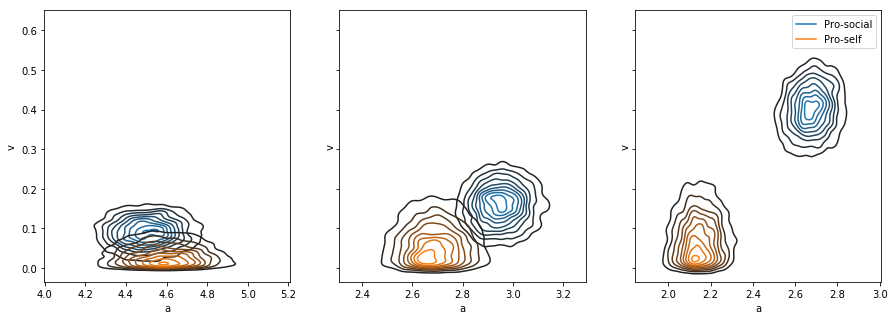

In [24]:
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharey = True)
count = 0
for r in [0,5,9]:
    sns.kdeplot(models_soc_m2[r].get_traces()["a"], np.abs(models_soc_m2[r].get_traces()["v"]), label = "Pro-social", ax=axes[count])
    sns.kdeplot(models_sel_m2[r].get_traces()["a"], np.abs(models_sel_m2[r].get_traces()["v"]),  label = "Pro-self", ax=axes[count])
    count = count + 1
plt.legend()

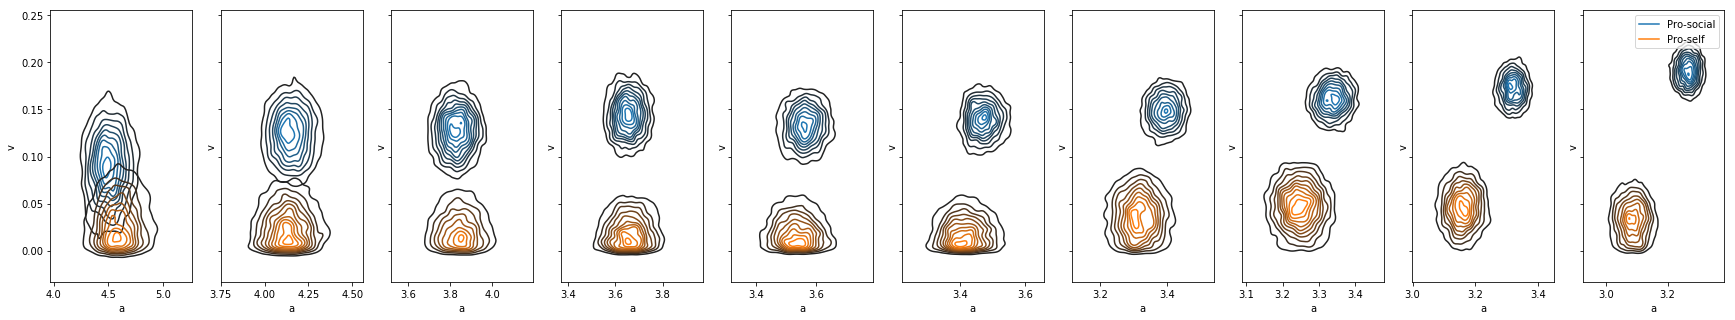

In [25]:
f, axes = plt.subplots(1, 10, figsize=(30, 5), sharey = True)
for r in range(0,10):
    sns.kdeplot(models_soc_m3[r].get_traces()["a"], np.abs(models_soc_m3[r].get_traces()["v"]), label = "Pro-social", ax=axes[r])
    sns.kdeplot(models_sel_m3[r].get_traces()["a"], np.abs(models_sel_m3[r].get_traces()["v"]),  label = "Pro-self", ax=axes[r])
plt.legend()

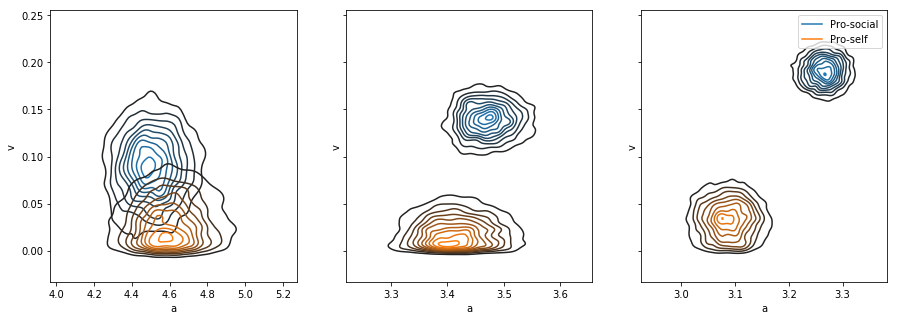

In [26]:
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharey = True)
count = 0
for r in [0,5,9]:
    sns.kdeplot(models_soc_m3[r].get_traces()["a"], np.abs(models_soc_m3[r].get_traces()["v"]), label = "Pro-social", ax=axes[count])
    sns.kdeplot(models_sel_m3[r].get_traces()["a"], np.abs(models_sel_m3[r].get_traces()["v"]),  label = "Pro-self", ax=axes[count])
    count += 1
plt.legend()

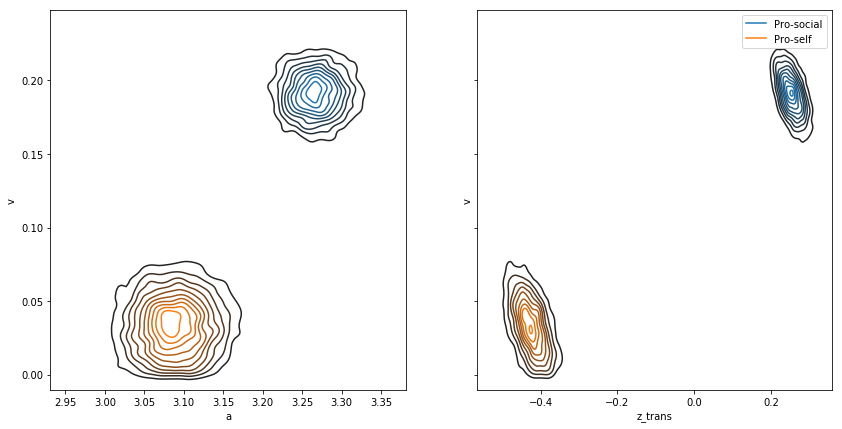

In [27]:
#Plotting parameters for the models

f, axes = plt.subplots(1, 2, figsize=(14, 7), sharey = True)
#plt.figure(figsize = (8,8))
sns.kdeplot(model_soc_m1.get_traces()["a"], np.abs(model_soc_m1.get_traces()["v"]), label = "Pro-social", ax=axes[0])
sns.kdeplot(model_sel_m1.get_traces()["a"], np.abs(model_sel_m1.get_traces()["v"]),  label = "Pro-self", ax=axes[0])

sns.kdeplot(model_soc_m1.get_traces()["z_trans"], np.abs(model_soc_m1.get_traces()["v"]), label = "Pro-social", ax=axes[1])
sns.kdeplot(model_sel_m1.get_traces()["z_trans"], np.abs(model_sel_m1.get_traces()["v"]),  label = "Pro-self", ax=axes[1])
plt.legend()

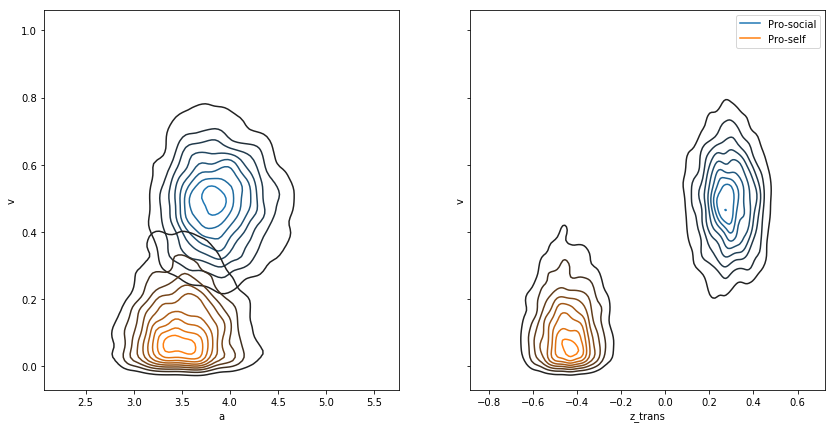

In [28]:
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharey = True)
#plt.figure(figsize = (8,8))
sns.kdeplot(model_soc_s1.get_traces()["a"], np.abs(model_soc_s1.get_traces()["v"]), label = "Pro-social", ax=axes[0])
sns.kdeplot(model_sel_s1.get_traces()["a"], np.abs(model_sel_s1.get_traces()["v"]),  label = "Pro-self", ax=axes[0])

sns.kdeplot(model_soc_s1.get_traces()["z_trans"], np.abs(model_soc_s1.get_traces()["v"]), label = "Pro-social", ax=axes[1])
sns.kdeplot(model_sel_s1.get_traces()["z_trans"], np.abs(model_sel_s1.get_traces()["v"]),  label = "Pro-self", ax=axes[1])
plt.legend()

In [29]:
sel_dist = modeler.get_stats(model_sel_s1, subjects= True)
sel_dist = sel_dist.loc[sel_dist.subject.notnull()]
soc_dist = modeler.get_stats(model_soc_s1, subjects= True)
soc_dist = soc_dist.loc[soc_dist.subject.notnull()]
soc_dist

,mean,std,2.5q,25q,50q,75q,97.5q,mc err,param,subject
2,3.04481,0.325756,2.5071,2.8115,3.01159,3.24012,3.75439,0.011678,a,s10n5_usuario3
3,3.72344,0.348199,3.129,3.47877,3.69811,3.94094,4.49708,0.0116453,a,s10n5_usuario4
4,1.93502,0.0951946,1.76082,1.86916,1.93126,1.99724,2.12952,0.0017907,a,s10n5_usuario7
5,1.77615,0.0886404,1.61341,1.71384,1.77247,1.83343,1.95776,0.0020828,a,s10n5_usuario8
6,7.01549,0.607034,5.96017,6.5968,6.96131,7.39278,8.35839,0.0212047,a,s4m8_usuario10
7,5.27606,0.277396,4.76683,5.07508,5.26978,5.46056,5.84151,0.00482059,a,s4m8_usuario11
8,2.87964,0.573329,2.0263,2.46324,2.78956,3.18119,4.28901,0.0348295,a,s4m8_usuario13
9,10.8007,1.79675,8.20448,9.49787,10.4915,11.8265,15.119,0.123046,a,s4m8_usuario14
10,2.88057,0.19269,2.52979,2.74871,2.86785,3.00588,3.28337,0.00443065,a,s4m8_usuario5
11,4.44483,0.736388,3.23359,3.9155,4.35832,4.90425,6.10097,0.0391599,a,s4m8_usuario6


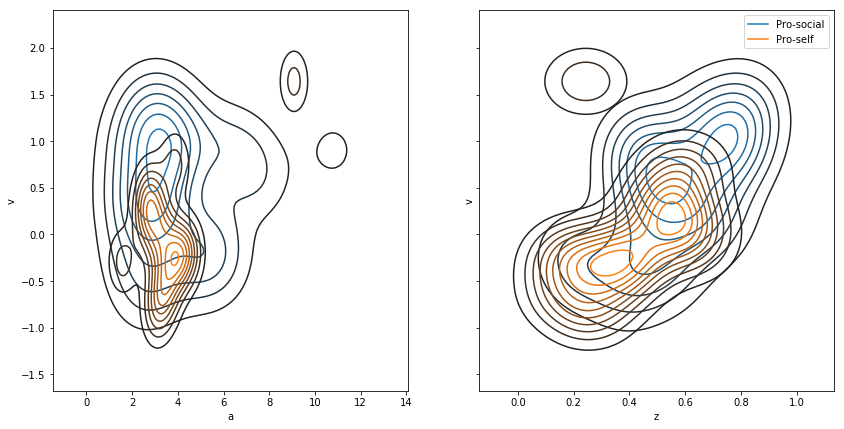

In [30]:
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharey = True)
#plt.figure(figsize = (8,8))
sns.kdeplot(soc_dist.loc[soc_dist.param == "a"]["mean"], soc_dist.loc[soc_dist.param == "v"]["mean"], label = "Pro-social", ax=axes[0])
sns.kdeplot(sel_dist.loc[sel_dist.param == "a"]["mean"], sel_dist.loc[sel_dist.param == "v"]["mean"], label = "Pro-self", ax=axes[0])

sns.kdeplot(soc_dist.loc[soc_dist.param == "z"]["mean"], soc_dist.loc[soc_dist.param == "v"]["mean"], label = "Pro-social", ax=axes[1])
sns.kdeplot(sel_dist.loc[sel_dist.param == "z"]["mean"], sel_dist.loc[sel_dist.param == "v"]["mean"], label = "Pro-self", ax=axes[1])
axes[0].set_xlabel("a")
axes[1].set_xlabel("z")
axes[0].set_ylabel("v")
axes[1].set_ylabel("v")
plt.legend()

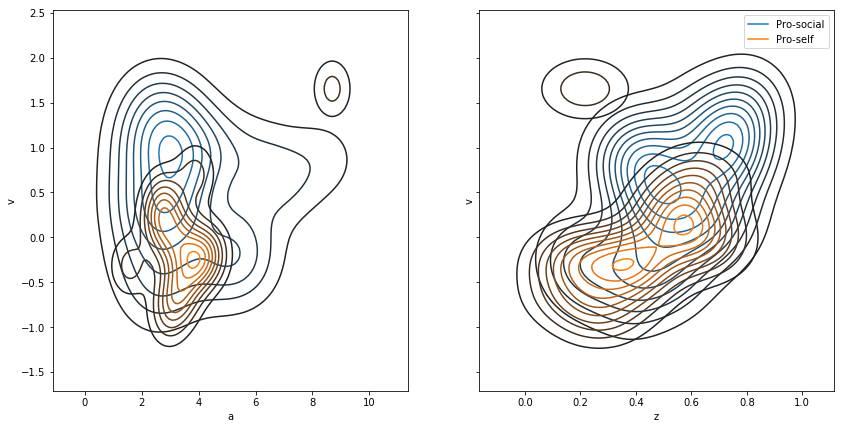

In [31]:
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharey = True)
#plt.figure(figsize = (8,8))
sns.kdeplot(stats_soc_s2.loc[stats_soc_s2.parameter == "a"]["mean"], stats_soc_s2.loc[stats_soc_s2.parameter == "v"]["mean"], label = "Pro-social", ax=axes[0])
sns.kdeplot(stats_sel_s2.loc[stats_sel_s2.parameter == "a"]["mean"], stats_sel_s2.loc[stats_sel_s2.parameter == "v"]["mean"], label = "Pro-self", ax=axes[0])

sns.kdeplot(stats_soc_s2.loc[stats_soc_s2.parameter == "z"]["mean"], stats_soc_s2.loc[stats_soc_s2.parameter == "v"]["mean"], label = "Pro-social", ax=axes[1])
sns.kdeplot(stats_sel_s2.loc[stats_sel_s2.parameter == "z"]["mean"], stats_sel_s2.loc[stats_sel_s2.parameter == "v"]["mean"], label = "Pro-self", ax=axes[1])
axes[0].set_xlabel("a")
axes[1].set_xlabel("z")
axes[0].set_ylabel("v")
axes[1].set_ylabel("v")
plt.legend()

In [32]:
test_subjects = actions.loc[actions.user.isin(test_fix.player.unique()), ["user", "type_adj"]]
test_subjects["predicted100m1"] = ""

for t in test_fix.player.unique():
    test_df = test_fix.loc[test_fix.player == t]
    model_test_100 = modeler.fit_model(test_df, 5000, 200)
    dist_soc = distance.euclidean(model_test_100.gen_stats()["mean"], model_soc_m1.gen_stats()["mean"])
    dist_self = distance.euclidean(model_test_100.gen_stats()["mean"], model_sel_m1.gen_stats()["mean"])
    pred = ""
    if dist_soc > dist_self:
        pred = "Pro-self"
    else:
        pred = "Pro-social"
    print("Self: %f, social: %f, pred: %s" % (dist_self, dist_soc, pred))
    test_subjects.loc[test_subjects.user == t, "predicted100m1"] = pred

 [-----------------100%-----------------] 5000 of 5000 complete in 5.7 secSelf: 0.587819, social: 0.864184, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 6.4 secSelf: 0.338315, social: 0.598286, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 8.6 secSelf: 0.744686, social: 0.717188, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 5.4 secSelf: 0.973167, social: 0.972440, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 4.6 secSelf: 1.484897, social: 1.638665, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 4.7 secSelf: 0.824830, social: 0.986430, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 4.3 secSelf: 1.545104, social: 1.704381, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 5.4 secSelf: 0.421980, social: 0.376806, pred: Pro-social
 [--------

In [33]:
test_subjects["predicted50m1"] = ""

for t in test_fix.player.unique():
    test_df = test_fix.loc[(test_fix.player == t) & (test_fix["round"] <= 50)]
    model_test = modeler.fit_model(test_df, 5000, 200)
    dist_soc = distance.euclidean(model_test.gen_stats()["mean"], model_soc_m1.gen_stats()["mean"])
    dist_self = distance.euclidean(model_test.gen_stats()["mean"], model_sel_m1.gen_stats()["mean"])
    pred = ""
    if dist_soc > dist_self:
        pred = "Pro-self"
    else:
        pred = "Pro-social"
    print("Self: %f, social: %f, pred: %s" % (dist_self, dist_soc, pred))
    test_subjects.loc[test_subjects.user == t, "predicted50m1"] = pred

 [-----------------100%-----------------] 5000 of 5000 complete in 5.8 secSelf: 0.398606, social: 0.671286, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 7.2 secSelf: 0.500315, social: 0.606497, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 10.6 secSelf: 1.543144, social: 1.421977, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 5.0 secSelf: 0.956673, social: 0.966186, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 4.6 secSelf: 1.260443, social: 1.468347, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 4.9 secSelf: 0.661232, social: 0.877396, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 4.0 secSelf: 1.214249, social: 1.399333, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 5.0 secSelf: 0.669773, social: 0.823774, pred: Pro-self
 [-----------

In [34]:
test_subjects["predicted20m1"] = ""

for t in test_fix.player.unique():
    test_df = test_fix.loc[(test_fix.player == t) & (test_fix["round"] <= 20)]
    model_test = modeler.fit_model(test_df, 5000, 200)
    dist_soc = distance.euclidean(model_test.gen_stats()["mean"], model_soc_m1.gen_stats()["mean"])
    dist_self = distance.euclidean(model_test.gen_stats()["mean"], model_sel_m1.gen_stats()["mean"])
    pred = ""
    if dist_soc > dist_self:
        pred = "Pro-self"
    else:
        pred = "Pro-social"
    print("Self: %f, social: %f, pred: %s" % (dist_self, dist_soc, pred))
    test_subjects.loc[test_subjects.user == t, "predicted20m1"] = pred

 [-----------------100%-----------------] 5000 of 5000 complete in 9.9 secSelf: 0.517962, social: 0.636722, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 11.5 secSelf: 1.200567, social: 1.120641, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 11.6 secSelf: 2.882739, social: 2.729355, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 6.8 secSelf: 1.251171, social: 1.113561, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 6.0 secSelf: 0.703092, social: 0.973008, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 10.3 secSelf: 0.983720, social: 1.199919, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 5.2 secSelf: 1.529536, social: 1.789399, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 10.7 secSelf: 0.616690, social: 0.743741, pred: Pro-self
 [----

In [35]:
test_subjects["predicted10m2"] = ""

for t in test_fix.player.unique():
    test_df = test_fix.loc[(test_fix.player == t) & (test_fix["round"] <= 20) & (test_fix["round"] > 10)]
    model_test = modeler.fit_model(test_df, 5000, 200)
    dist_soc = distance.euclidean(model_test.gen_stats()["mean"], models_soc_m2[0].gen_stats()["mean"])
    dist_self = distance.euclidean(model_test.gen_stats()["mean"], models_sel_m2[0].gen_stats()["mean"])
    pred = ""
    if dist_soc > dist_self:
        pred = "Pro-self"
    else:
        pred = "Pro-social"
    print("Self: %f, social: %f, pred: %s" % (dist_self, dist_soc, pred))
    test_subjects.loc[test_subjects.user == t, "predicted10m2"] = pred

 [-----------------100%-----------------] 5000 of 5000 complete in 8.5 secSelf: 2.458028, social: 2.367822, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 10.3 secSelf: 0.904757, social: 0.821781, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 10.8 secSelf: 0.492858, social: 0.505213, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 8.4 secSelf: 1.627273, social: 1.497356, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 5.5 secSelf: 2.912987, social: 2.850924, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 10.6 secSelf: 2.283720, social: 2.198783, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 6.0 secSelf: 2.832947, social: 2.749012, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 10.8 secSelf: 1.459629, social: 1.364582, pred: Pro-socia

In [36]:
test_subjects["predicted1020_m2"] = ""

for t in test_fix.player.unique():
    test_df = test_fix.loc[(test_fix.player == t) & (test_fix["round"] <= 20) & (test_fix["round"] > 10)]
    model_test = modeler.fit_model(test_df, 5000, 200)
    dist_soc = distance.euclidean(model_test.gen_stats()["mean"], models_soc_m2[1].gen_stats()["mean"])
    dist_self = distance.euclidean(model_test.gen_stats()["mean"], models_sel_m2[1].gen_stats()["mean"])
    pred = ""
    if dist_soc > dist_self:
        pred = "Pro-self"
    else:
        pred = "Pro-social"
    print("Self: %f, social: %f, pred: %s" % (dist_self, dist_soc, pred))
    test_subjects.loc[test_subjects.user == t, "predicted1020_m2"] = pred

 [-----------------100%-----------------] 5000 of 5000 complete in 8.5 secSelf: 1.457492, social: 1.615726, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 10.3 secSelf: 0.392737, social: 0.476944, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 10.7 secSelf: 1.365025, social: 1.260810, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 7.9 secSelf: 1.129447, social: 1.015532, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 5.3 secSelf: 1.937709, social: 2.131398, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 9.9 secSelf: 1.373678, social: 1.548863, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 5.9 secSelf: 1.841433, social: 2.002019, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 10.7 secSelf: 0.517813, social: 0.664265, pred: Pro-self
 [-------

In [37]:
test_subjects["predicted20_m3"] = ""

for t in test_fix.player.unique():
    test_df = test_fix.loc[(test_fix.player == t) & (test_fix["round"] <= 20)]
    model_test = modeler.fit_model(test_df, 5000, 200)
    dist_soc = distance.euclidean(model_test.gen_stats()["mean"], models_soc_m3[1].gen_stats()["mean"])
    dist_self = distance.euclidean(model_test.gen_stats()["mean"], models_sel_m3[1].gen_stats()["mean"])
    pred = ""
    if dist_soc > dist_self:
        pred = "Pro-self"
    else:
        pred = "Pro-social"
    print("Self: %f, social: %f, pred: %s" % (dist_self, dist_soc, pred))
    test_subjects.loc[test_subjects.user == t, "predicted20_m3"] = pred

 [-----------------100%-----------------] 5000 of 5000 complete in 9.3 secSelf: 0.897042, social: 0.953010, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 11.2 secSelf: 0.440932, social: 0.492331, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 12.1 secSelf: 1.866862, social: 1.849578, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 6.7 secSelf: 1.353986, social: 1.274591, pred: Pro-social
 [-----------------100%-----------------] 5000 of 5000 complete in 6.3 secSelf: 1.676281, social: 1.724843, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 10.2 secSelf: 1.481474, social: 1.548170, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 4.9 secSelf: 2.387192, social: 2.445526, pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 10.1 secSelf: 0.976759, social: 1.031605, pred: Pro-self
 [------

In [38]:
test_subjects

,user,type_adj,predicted100m1,predicted50m1,predicted20m1,predicted10m2,predicted1020_m2,predicted20_m3
32,s8n3_usuario4,Pro-social,Pro-self,Pro-self,Pro-self,Pro-social,Pro-self,Pro-self
33,s8n3_usuario9,Pro-self,Pro-self,Pro-self,Pro-social,Pro-social,Pro-self,Pro-self
34,s8n3_usuario2,Pro-self,Pro-social,Pro-social,Pro-social,Pro-self,Pro-social,Pro-social
35,s8n3_usuario14,Pro-social,Pro-social,Pro-self,Pro-social,Pro-social,Pro-social,Pro-social
36,s8n3_usuario7,Pro-social,Pro-self,Pro-self,Pro-self,Pro-social,Pro-self,Pro-self
37,s8n3_usuario13,Pro-self,Pro-self,Pro-self,Pro-self,Pro-social,Pro-self,Pro-self
40,s8n3_usuario10,Pro-self,Pro-self,Pro-self,Pro-self,Pro-social,Pro-self,Pro-self
41,s8n3_usuario17,Pro-social,Pro-social,Pro-self,Pro-self,Pro-social,Pro-self,Pro-self
58,s9n3_usuario9,Pro-self,Pro-social,Pro-social,Pro-social,Pro-social,Pro-self,Pro-self
59,s9n3_usuario11,Pro-social,Pro-social,Pro-self,Pro-self,Pro-social,Pro-self,Pro-self


In [239]:
soc_dist.loc[(soc_dist.subject == "s10n5_usuario3") & (soc_dist.param.isin(["a", "v", "t", "z"]))]["mean"].values

array([3.0173368180728706, 0.8114865167806177, 0.48790055533133303,
       0.7375558785063352], dtype=object)

In [163]:
subj_params = []
for subj_idx, subj_data in train_fix.groupby('player'):
    m_subj = hddm.HDDM(subj_data, bias = True)
    params_dict = m_subj.optimize('chisquare')
    params_dict["subject"] = subj_idx
    subj_params.append(params_dict)
params = pd.DataFrame(subj_params)

Optimization terminated successfully.
         Current function value: 18.454725
         Iterations: 10
         Function evaluations: 655
Optimization terminated successfully.
         Current function value: 18.454728
         Iterations: 8
         Function evaluations: 567
Optimization terminated successfully.
         Current function value: 18.454718
         Iterations: 8
         Function evaluations: 468
Optimization terminated successfully.
         Current function value: 20.369408
         Iterations: 7
         Function evaluations: 441
Optimization terminated successfully.
         Current function value: 20.369443
         Iterations: 4
         Function evaluations: 232
Optimization terminated successfully.
         Current function value: 20.369421
         Iterations: 8
         Function evaluations: 529
Optimization terminated successfully.
         Current function value: 10.807699
         Iterations: 9
         Function evaluations: 545
Optimization terminated su

Optimization terminated successfully.
         Current function value: 7266.668158
         Iterations: 6
         Function evaluations: 696
Optimization terminated successfully.
         Current function value: 30.121776
         Iterations: 11
         Function evaluations: 706
Optimization terminated successfully.
         Current function value: 30.121711
         Iterations: 18
         Function evaluations: 1004
Optimization terminated successfully.
         Current function value: 30.121742
         Iterations: 9
         Function evaluations: 579
Optimization terminated successfully.
         Current function value: 41.648680
         Iterations: 5
         Function evaluations: 289
Optimization terminated successfully.
         Current function value: 41.648806
         Iterations: 5
         Function evaluations: 281
Optimization terminated successfully.
         Current function value: 41.648731
         Iterations: 7
         Function evaluations: 456
Optimization terminate

Optimization terminated successfully.
         Current function value: 14.574199
         Iterations: 8
         Function evaluations: 516
Optimization terminated successfully.
         Current function value: 14.574197
         Iterations: 9
         Function evaluations: 566


In [188]:
s1_params = params.merge(actions[["type", "user"]], left_on = "subject", right_on = "user")
s1_params

,a,v,t,z_trans,z,subject,type,user
0,4.158109,-0.254604,3.148245e-02,-0.652310,0.342469,s10n5_usuario1,Pro-self,s10n5_usuario1
1,2.989481,-0.123384,6.668015e-01,-0.229806,0.442800,s10n5_usuario2,Pro-self,s10n5_usuario2
2,2.531977,0.773984,4.984520e-01,0.895961,0.710119,s10n5_usuario3,Pro-social,s10n5_usuario3
3,3.838329,0.616670,2.456834e-01,0.647144,0.656367,s10n5_usuario4,Pro-social,s10n5_usuario4
4,1.882096,-0.168790,3.285496e-01,-0.517201,0.373507,s10n5_usuario7,Pro-self,s10n5_usuario7
5,1.826603,0.443384,3.337972e-01,-0.027081,0.493230,s10n5_usuario8,Pro-social,s10n5_usuario8
6,2.703833,0.138398,3.313232e-01,0.295886,0.573436,s4m8_usuario1,Pro-social,s4m8_usuario1
7,18.710461,1.550441,6.136000e-03,0.428858,0.605601,s4m8_usuario10,Pro-social,s4m8_usuario10
8,5.237835,-0.010463,5.112860e-01,0.902658,0.711495,s4m8_usuario11,Pro-social,s4m8_usuario11
9,4.374724,1.617594,3.375194e+00,-0.609631,0.352143,s4m8_usuario12,Pro-social,s4m8_usuario12


In [39]:
for t in test_fix.player.unique():
    test_df = test_fix.loc[(test_fix.player == t)]
    model_test = modeler.fit_model(test_df, 5000, 200)
    test_vals = model_test.gen_stats()["mean"].values
    dist_soc = []
    for s in soc_dist.subject.unique():
        vals = soc_dist.loc[(soc_dist.subject == s) & (soc_dist.param.isin(["a", "v", "t", "z"]))]["mean"].values
        dist_soc.append(distance.euclidean(test_vals, vals))
    dist_sel = []
    for s in sel_dist.subject.unique():
        vals = sel_dist.loc[(sel_dist.subject == s) & (sel_dist.param.isin(["a", "v", "t", "z"]))]["mean"].values
        dist_sel.append(distance.euclidean(test_vals, vals))
    pred = ""
    if np.mean(dist_soc) > np.mean(dist_sel):
        pred = "Pro-self"
    else:
        pred = "Pro-social"
    print("soc %f sel %f pred: %s" % (np.mean(dist_soc),np.mean(dist_sel), pred))
    test_subjects.loc[test_subjects.user == t, "predicteds1"] = pred

 [-----------------100%-----------------] 5000 of 5000 complete in 5.5 secsoc 2.074609 sel 1.442233 pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 6.6 secsoc 1.924941 sel 1.190594 pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 9.0 secsoc 1.805387 sel 1.208244 pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 5.4 secsoc 1.912052 sel 1.704958 pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 4.6 secsoc 2.493988 sel 2.175226 pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 4.5 secsoc 2.073511 sel 1.594474 pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 4.1 secsoc 2.624550 sel 2.241918 pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 5.9 secsoc 1.761867 sel 1.299534 pred: Pro-self
 [-----------------100%-----------------] 5000 of 5000 complete in 7.2 secsoc 1.

In [40]:
dist_sel

[1.2068755951567192,
 0.4798041991139362,
 0.43974527410570907,
 6.605909535347509,
 1.5087829780797468,
 0.7284302487379049,
 0.5559425572671959,
 1.7498973606038015,
 1.2185796396614659,
 0.7407508300014837,
 0.8639339789012058,
 0.8497704247018489,
 0.6173834309758846,
 1.3465771954977872,
 1.1128699350505846]

In [41]:
dist_soc

[1.1246802027190161,
 1.3448402380103024,
 0.8800049481481954,
 1.2395964875825805,
 4.3594846714353634,
 2.501391286439764,
 1.6855643510158214,
 8.08156882619343,
 0.38175445028571015,
 2.076975672198829,
 1.2843429727936375,
 0.757767279113435,
 4.835941385725535,
 1.6041706667756008,
 0.5489141641900669,
 0.7127343849996328,
 1.5448225543388994,
 1.5209921876162997,
 2.978249941625912,
 2.7222632918246323,
 1.5560753242366963,
 0.7889099111522527,
 3.504690250446943,
 1.8159719611150182,
 0.5455534456627769]